In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


        
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

cuda:0
/kaggle/input/results-log/philosophy_logs.csv
/kaggle/input/results-log/cpp_logs.csv
/kaggle/input/mech-interp-data/cpp_numbered_qa.json
/kaggle/input/mech-interp-data/python_numbered_qa.json
/kaggle/input/mech-interp-data/numbered_qa_strings.json


# 1. Dataset

In [5]:
import os
import json
import torch
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

#  Load JSON Data ----
with open("/kaggle/input/mech-interp-data/cpp_numbered_qa.json", "r") as f:
    data = json.load(f)

texts = list(data.values())


# 2. Loading the Model



In [6]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
token = user_secrets.get_secret("3b_token")
login(token=token)

from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B", token=token)

local_dir= "/kaggle/working/llama-3.2-3b"
if not os.path.exists(local_dir):
    model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B", torch_dtype=torch.float16,token=token)
    model.save_pretrained(local_dir)
else:
    model = AutoModelForCausalLM.from_pretrained(local_dir, torch_dtype=torch.float16)

model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

2025-06-08 05:58:48.855579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749362329.397633      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749362329.525385      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

# 3. Hook setup

In [ ]:
# ---- Hook Setup ----
hook_storage = {}

def set_hook(name):
    def hook(model, input, output):
        if isinstance(output, tuple):
            output = output[0]
        hook_storage[name] = output.detach().cpu()  # move to CPU to save VRAM
    return hook

# ---- Register Hooks Once ----
for i, layer in enumerate(model.model.layers):
    layer.register_forward_hook(set_hook(f"layer-{i}"))


# 4. Running FP for all text sequences

In [ ]:
import pandas as pd
from tqdm import tqdm

# ---- Process Texts ----
num_layers = len(model.model.layers)
all_mean_deltas = [[] for _ in range(num_layers - 1)]
all_abs_mean_deltas = [[] for _ in range(num_layers - 1)]

for text in tqdm(texts):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    hook_storage.clear()

    with torch.no_grad():
        _ = model(**inputs)

    layer_outputs = [hook_storage[f"layer-{i}"] for i in range(num_layers)]

    for i in range(num_layers - 1):
        delta = layer_outputs[i + 1] - layer_outputs[i]
        all_mean_deltas[i].append(delta.mean().item())
        all_abs_mean_deltas[i].append(delta.abs().mean().item())

# ---- Compute Final Averages ----
mean_deltas = [sum(layer) / len(layer) for layer in all_mean_deltas]
abs_mean_deltas = [sum(layer) / len(layer) for layer in all_abs_mean_deltas]

# ---- Save as CSV ----
df = pd.DataFrame({
    "layer": list(range(num_layers - 1)),
    "mean_delta": mean_deltas,
    "abs_mean_delta": abs_mean_deltas
})
df.to_csv("layer_deltas.csv", index=False)


# 5. plotting results

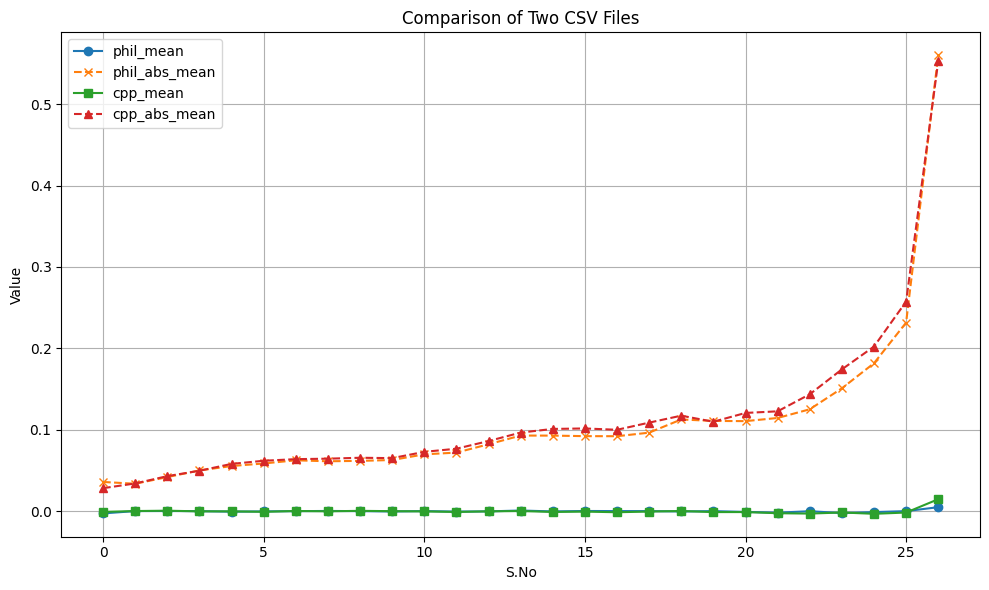

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSVs
csv1 = pd.read_csv("/kaggle/input/results-log/philosophy_logs.csv")
csv2 = pd.read_csv("/kaggle/input/results-log/cpp_logs.csv")

# Plot settings
plt.figure(figsize=(10, 6))

# Plot CSV 1
plt.plot(csv1.iloc[:, 0], csv1.iloc[:, 1], label='phil_mean', linestyle='-', marker='o')
plt.plot(csv1.iloc[:, 0], csv1.iloc[:, 2], label='phil_abs_mean', linestyle='--', marker='x')

# Plot CSV 2
plt.plot(csv2.iloc[:, 0], csv2.iloc[:, 1], label='cpp_mean', linestyle='-', marker='s')
plt.plot(csv2.iloc[:, 0], csv2.iloc[:, 2], label='cpp_abs_mean', linestyle='--', marker='^')

# Decorations
plt.xlabel('S.No')
plt.ylabel('Value')
plt.title('Comparison of Two CSV Files')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
